# Setup

In [1]:
import sys
sys.path.append("../Reproduction/Code")
sys.path.append("../Reproduction/scvis/lib/scvis")

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# ELDR Heart

In [3]:
# Chosen using results from Heart-K
epsilon = 1.0
k = 3

input_dim = 13
num_clusters = 8
num_classes = 2
model_file = "../Reproduction/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"

feature_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"]

import csv
import json
import numpy as np
import os
import pandas as pd

os.system("rm *.png")

import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from load_scvis import load_vae
from metrics import metrics, eval_epsilon
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation, plot_change
from misc import poly2labels

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
# Load Data & Configuration

x = pd.read_csv("../Reproduction/Heart/Data/X.tsv", sep="\t").values

y = pd.read_csv("../Reproduction/Heart/Data/y.tsv", sep="\t").values


with open("../Reproduction/Heart/vertices.json") as json_file:  
    all_vertices = json.load(json_file)


In [5]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



INFO:tensorflow:Restoring parameters from /content/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


In [ ]:
from sklearn.mixture import GaussianMixture

# kmeans = KMeans(n_clusters=num_clusters).fit(rep_np)
gm = GaussianMixture(n_components=num_clusters, covariance_type='diag').fit(data_rep)
eps = np.mean(np.sqrt(gm.covariances_))
print(eps)

1.3182250753494769


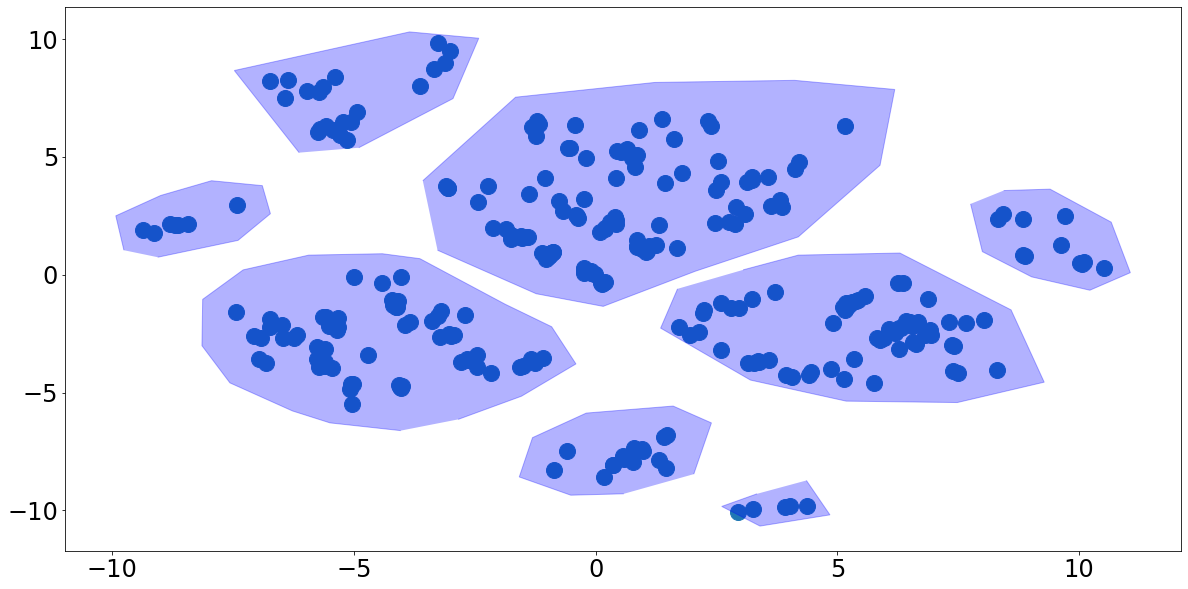

In [6]:
# Visualize the data and the marked clusters

plot_polys(data_rep, all_vertices)

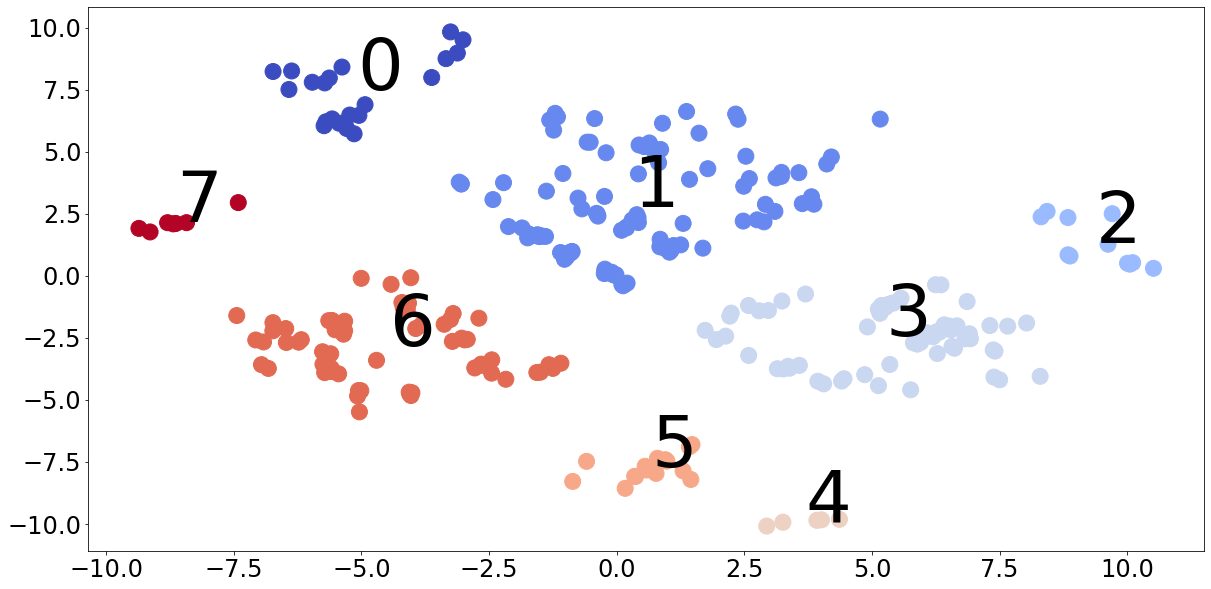

In [7]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "heart-rep.png")


In [ ]:
# Inspect the correlation between cluster and class

confusion  = np.zeros((num_clusters, num_classes))
for i in range(y.shape[0]):
    if labels[i] != -1.0:
        confusion[int(labels[i]), int(y[i])] += 1
    
print(confusion)

[[ 6. 15.]
 [46. 62.]
 [10.  1.]
 [52. 14.]
 [ 4.  1.]
 [10.  7.]
 [ 8. 59.]
 [ 2.  5.]]


INFO:tensorflow:Restoring parameters from /content/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


/content/ELDR/Code/myplot.py:105: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/axes_grid1/axes_grid.py:51: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


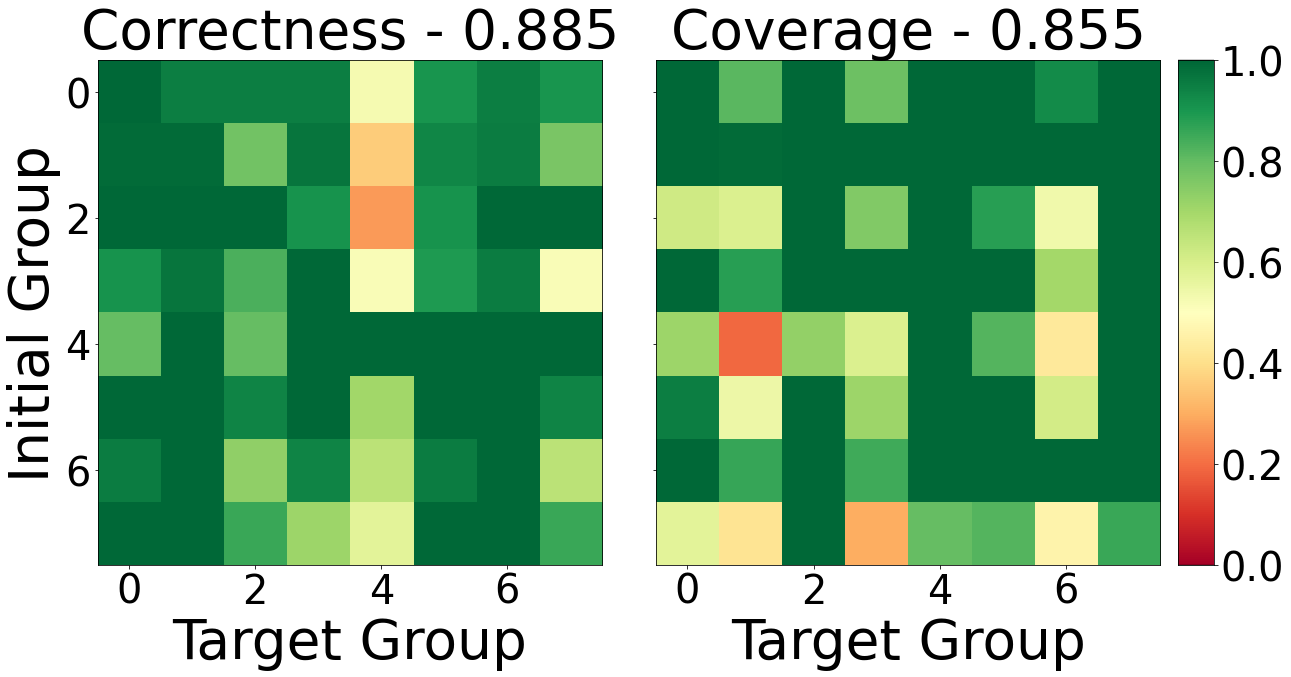

INFO:tensorflow:Restoring parameters from /content/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


ValueError: ignored

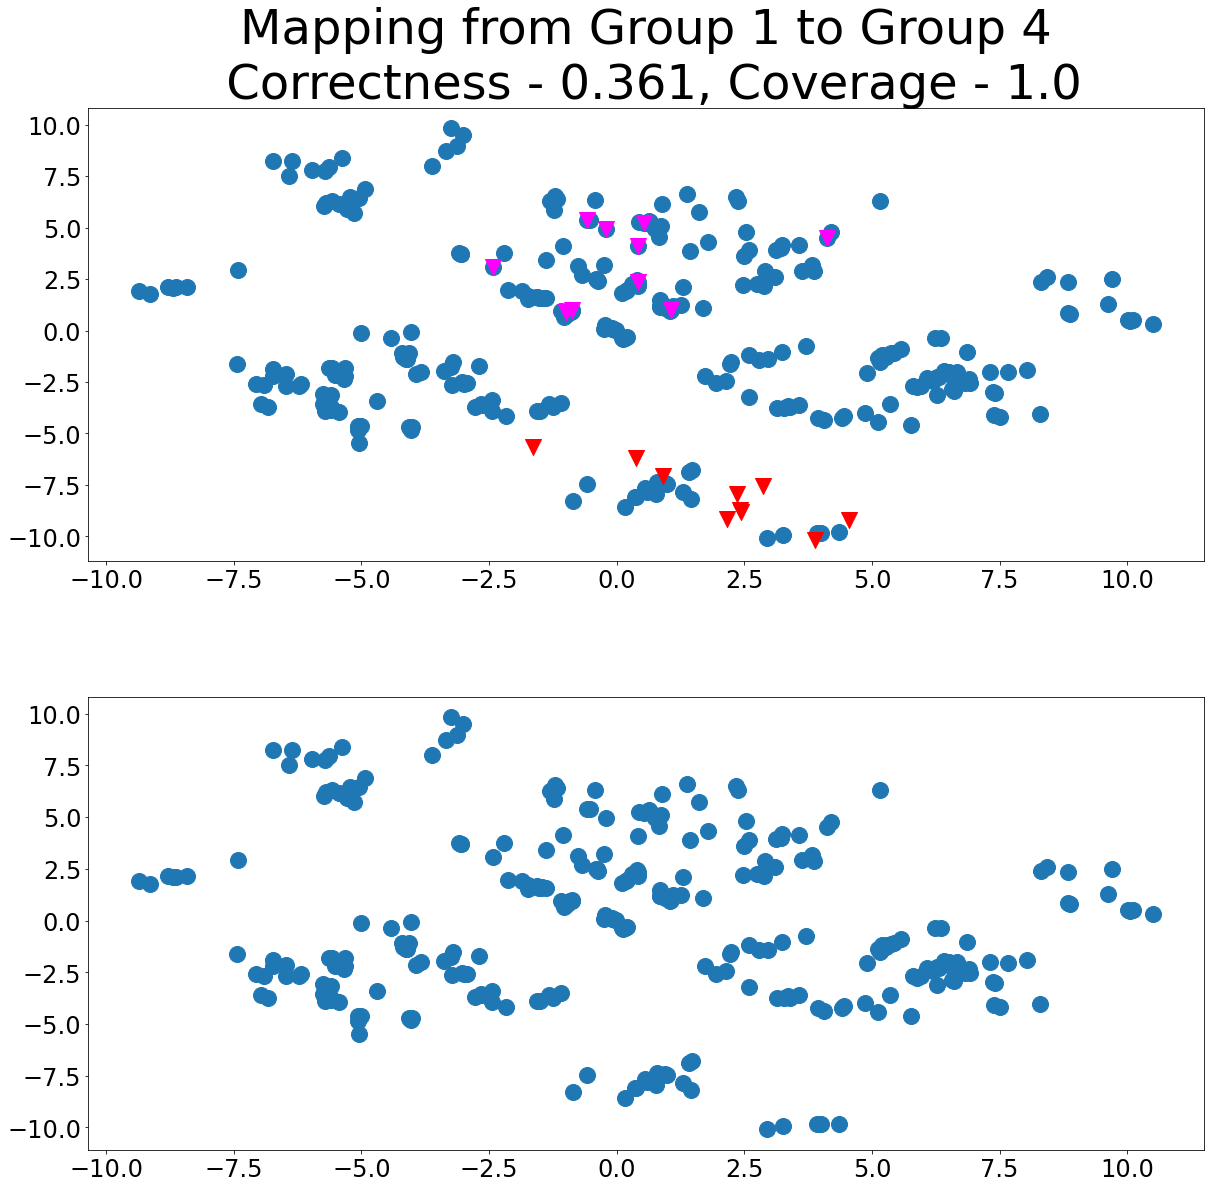

In [9]:
# Evaluate the explanations

deltas = np.load("../Reproduction/Heart-K/deltas" + str(k) + ".npy")

a, b = metrics(load_model, x, indices, deltas, epsilon, k = k)

plot_metrics(a, b, name = "heart-metrics.png")

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 1, 4, k = k, name = "heart-1to4.png", num_points = 10, feature_names = feature_names)

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 4, 7, k = k,  name = "heart-4to7.png", num_points = 10, feature_names = feature_names)

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 1, 7, k = k,  name = "heart-1to7.png", num_points = 20, feature_names = feature_names)


In [10]:
# Columns are:  K, TGT-correctness, TGT-coverage, DBM-correctness, DBM-coverage
K = range(1,num_clusters+1)
out = np.zeros((len(K), 4))

best_deltas = np.zeros((num_clusters - 1, input_dim))

# Evaluate TGTs
for c,k in enumerate(K):
  best_val = 0.0
  for lg in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
      for trial in range(3):

          deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = lg)
          a, b = metrics(load_model, x, indices, deltas, epsilon, k = k) 

          val = np.mean(a)

          if val > best_val:
              best_deltas = deltas
              best_val = val
              out[c, 0] = best_val
              out[c, 1] = np.mean(b)
# Evaluate DBMs
exp_mean = np.zeros((num_clusters - 1, input_dim))
for i in range(num_clusters - 1):
    exp_mean[i, :] = means[i + 1] - means[0]

for c,k in enumerate(K):
    a, b = metrics(load_model, x, indices, exp_mean, epsilon, k = k)
    out[c, 2] = np.mean(a)
    out[c, 3] = np.mean(b)

print(out)

INFO:tensorflow:Restoring parameters from /content/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt



INFO:tensorflow:Restoring parameters from /content/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /content/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /content/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /content/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:R

In [11]:
def eval_classification(X, labels, deltas, dbms, k):

  from sklearn.linear_model import LogisticRegression
  from sklearn.metrics import accuracy_score

  num_clusters = len(np.unique(labels))
  tgt_features = [np.argpartition(deltas[i],-k)[-k:].tolist() for i in range(num_clusters - 1)]
  dbm_features = [np.argpartition(dbms[i],-k)[-k:].tolist() for i in range(num_clusters -1)]

  ##### TGT ######

  # train classifiers
  clfs = []
  for c, idxs in enumerate(tgt_features):
    kx = X[:,idxs]
    ky = (labels == c).astype(int)
    clf = LogisticRegression().fit(kx, ky)
    clfs.append(clf)

  # predict using one-vs-rest ensemble
  preds = []
  for i in range(x.shape[0]):
    probs = []
    for c in range(num_clusters-1):
      pred = clfs[c].predict_proba(x[i, tgt_features[c]].reshape(1, -1))
      probs.append(pred[:,1][0])
    preds.append(np.argmax(probs))

  tgt_acc = accuracy_score(labels, preds)
  
  ##### DBM ######
  clfs = []
  for c, idxs in enumerate(dbm_features):
    kx = X[:,idxs]
    ky = (labels == c).astype(int)
    clf = LogisticRegression().fit(kx, ky)
    clfs.append(clf)

  # predict using one-vs-rest ensemble
  preds = []
  for i in range(x.shape[0]):
    probs = []
    for c in range(num_clusters-1):
      pred = clfs[c].predict_proba(x[i, dbm_features[c]].reshape(1, -1))
      probs.append(pred[:,1][0])
    preds.append(np.argmax(probs))
  
  dbm_acc = accuracy_score(labels, preds)

  return [tgt_acc, dbm_acc]

In [19]:
tgt_res = []
dbm_res = []
num_features = range(1,input_dim + 1)
for k in num_features:
  res = eval_classification(x, labels, best_deltas, exp_mean, k)
  tgt_res.append(res[0])
  dbm_res.append(res[1])

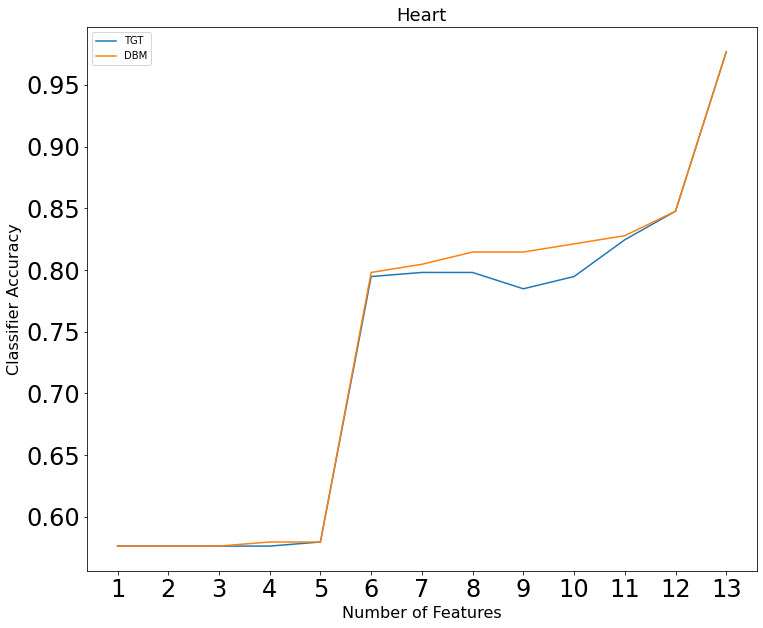

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.plot(num_features, tgt_res, label='TGT')
plt.plot(num_features, dbm_res, label='DBM')
plt.xticks(num_features)
plt.title('Heart',  fontsize=18)
plt.xlabel('Number of Features', fontsize=16)
plt.ylabel('Classifier Accuracy', fontsize=16)
plt.legend()
plt.show()

## Corrupted data

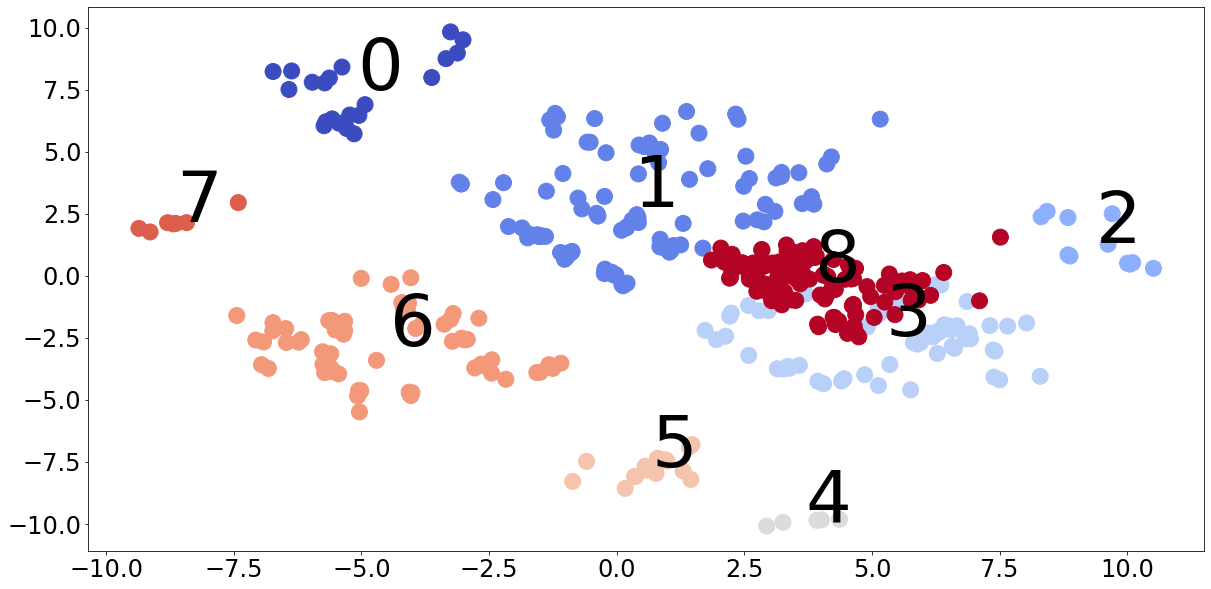

In [ ]:
# Let's "corrupt" one of the groups

corrupt = False
target_corrupted = 1

if corrupt:

    indices_corrupted = np.where(labels == target_corrupted)
    n_corrupted = len(indices_corrupted[0])

    x_corrupted = x[indices_corrupted]
    x_corrupted[:, 6] -= 0.9 + np.random.uniform(low = -0.1, high = 0.1, size = n_corrupted)
    x_corrupted[:, 8] += 0.6 + np.random.uniform(low = -0.1, high = 0.1, size = n_corrupted)

    x_full = np.vstack((x, x_corrupted))

    np.savetxt("../Reproduction/Heart/Data/X_corrupted.tsv", x_full, delimiter = "\t")

    labels_full = np.vstack((np.expand_dims(labels, 1), num_clusters * np.ones((n_corrupted,1))))

    np.savetxt("../Reproduction/Heart/Data/labels_corrupted.tsv", labels_full, delimiter = "\t")
else:
    x_full = np.loadtxt("../Reproduction/Heart/Data/X_corrupted.tsv", delimiter = "\t")
    labels_full = np.loadtxt("../Reproduction/Heart/Data/labels_corrupted.tsv", delimiter = "\t")

# Compute the new representation
data_rep_full = sess.run(rep, feed_dict={X: x_full, D: np.zeros((1, input_dim))})

# Visualize the clusters in the learned representation
means_full, centers_full, indices_full = plot_groups(x_full, data_rep_full, num_clusters + 1, labels_full, name = "heart-rep-corrupted.png")


In [ ]:
# Compute the group explanations

run = False

if run:
    os.system("rm deltas_corrupted.npy")
    
    best_val = 0.0
    for lg in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
        for trial in range(5):

            deltas = explain(load_model, means_full, centers_full, learning_rate = 0.01, consecutive_steps = 5, lambda_global = lg)
            a, b = metrics(load_model, x_full, indices, deltas, epsilon, k = k) 

            val = np.mean(a)

            if val > best_val:
                best_val = val
                np.save("deltas_corrupted.npy", deltas)

            os.system("rm -rf explanation")

INFO:tensorflow:Restoring parameters from /content/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


/content/ELDR/Code/myplot.py:105: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)


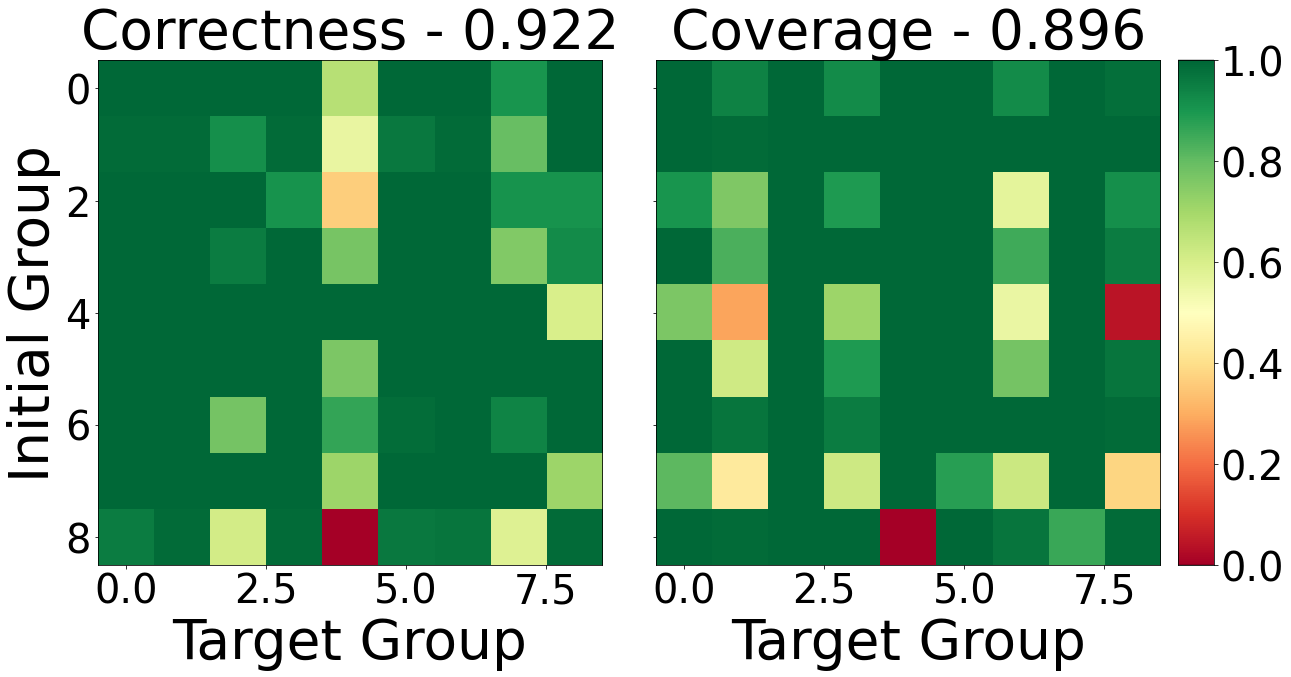

INFO:tensorflow:Restoring parameters from /content/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /content/ELDR/Heart/Model/model/perplexity_10_regularizer_0.001_batch_size_302_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


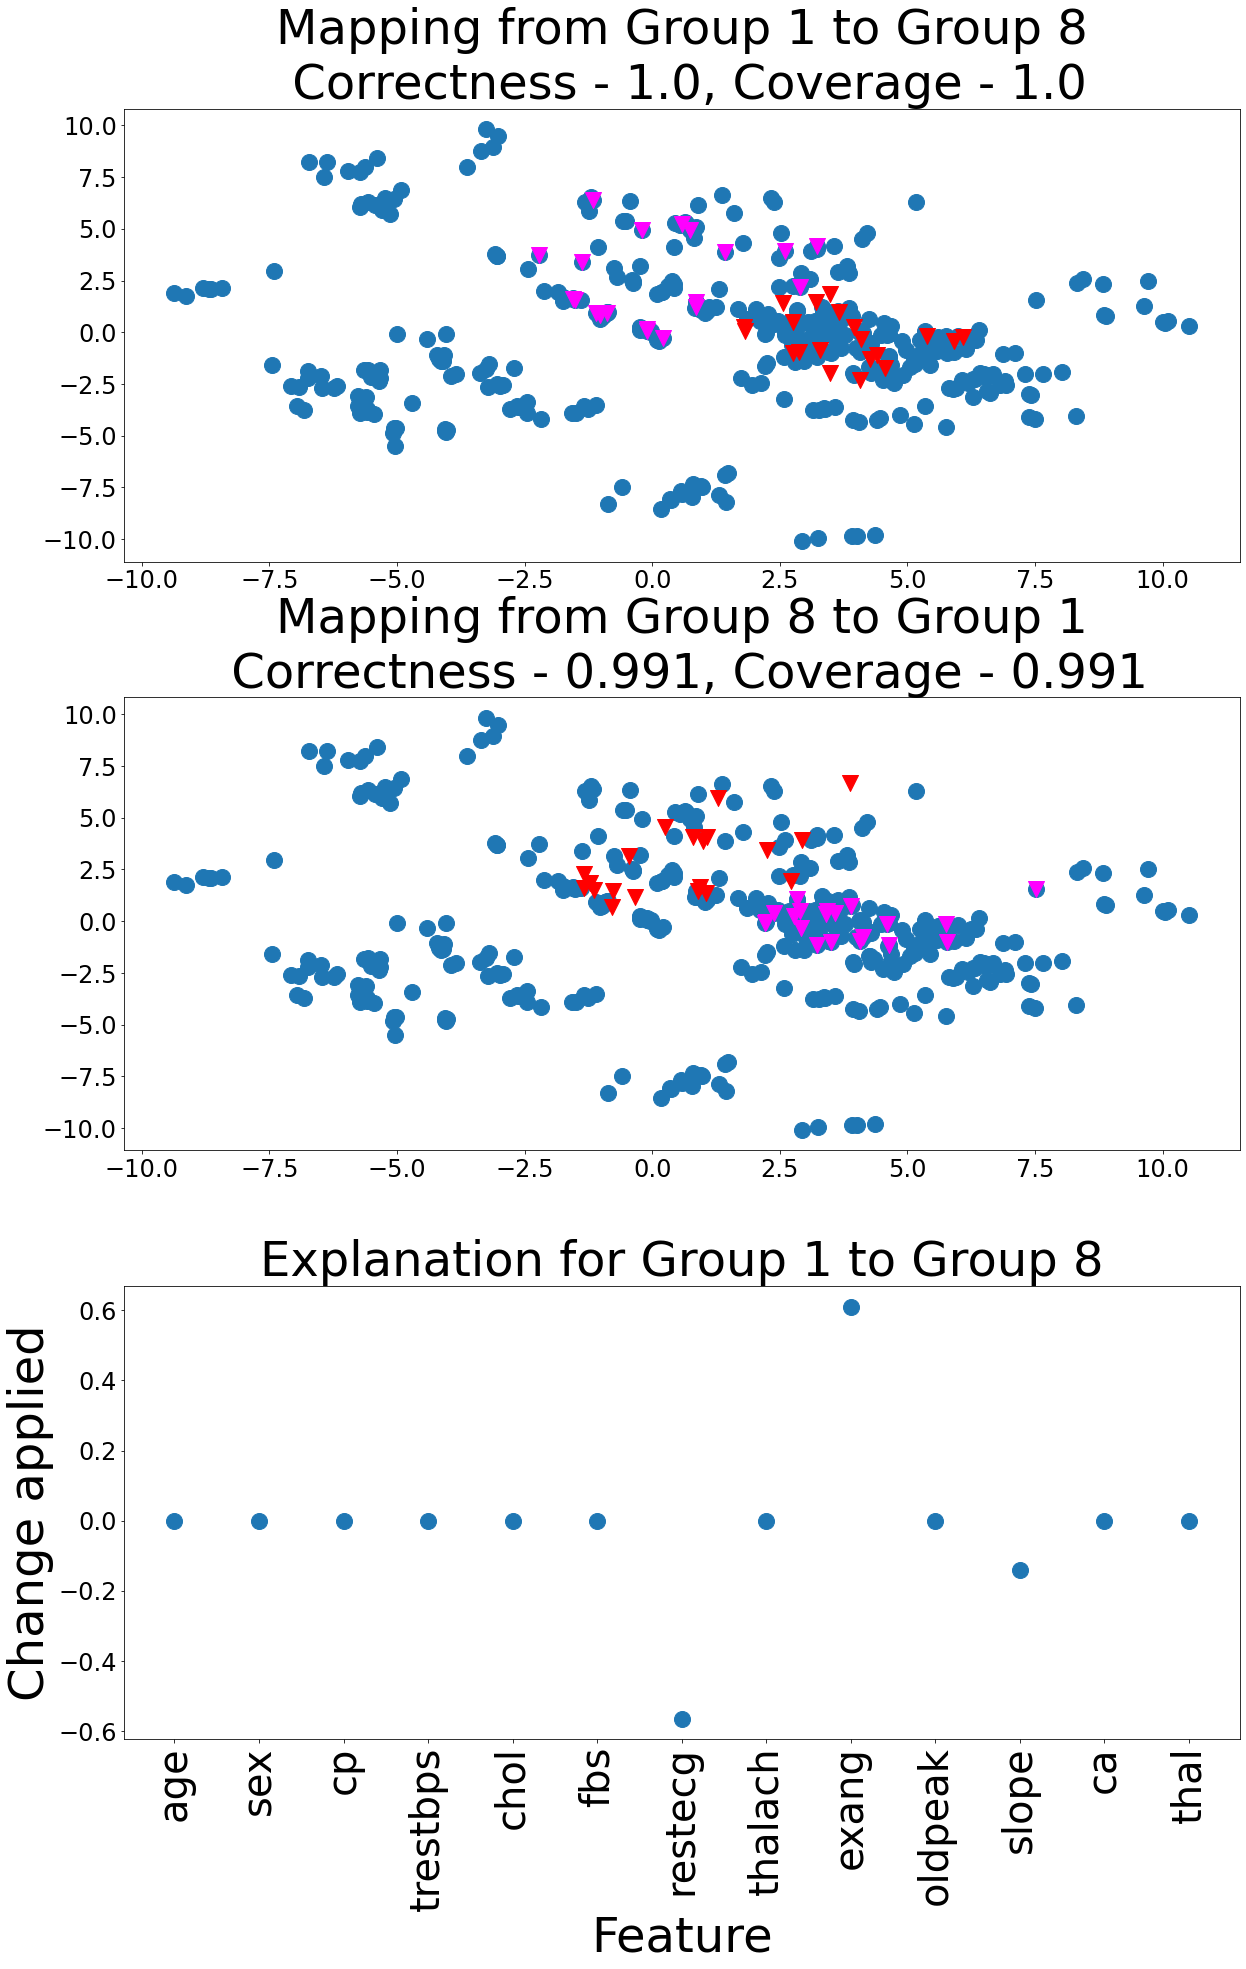

In [ ]:
# Evaluate the explanations

deltas = np.load("../Reproduction/Heart/deltas_corrupted.npy")

a, b = metrics(load_model, x_full, indices_full, deltas, eps, k = k)

plot_metrics(a, b, name = "heart-metrics-corrupted.png")

plot_explanation(load_model, x_full, data_rep_full, indices_full, deltas, a, b, target_corrupted, num_clusters, k = k, name = "heart-t2c.png", num_points = 20, feature_names = feature_names)


[[ 0.    0.21 -0.13  0.    0.   -0.71  0.    0.   -0.14 -0.   -0.02 -0.
   0.  ]
 [-0.    0.14 -0.42 -0.    0.   -0.53  0.03 -0.01  0.91 -0.   -0.1   0.01
   0.  ]
 [ 0.    0.96 -0.01 -0.    0.    0.01 -0.    0.   -0.02 -0.   -0.18 -0.
  -0.  ]
 [ 0.    1.02 -0.32 -0.    0.   -0.02 -0.03  0.    1.01  0.   -0.32  0.
   0.  ]
 [-0.    1.07 -0.15 -0.   -0.   -0.89  0.03  0.01 -0.13 -0.    0.16 -0.02
  -0.  ]
 [ 0.    1.15 -0.18 -0.   -0.   -0.79  0.    0.   -0.09  0.   -0.31 -0.01
   0.  ]
 [ 0.    1.1  -0.43 -0.   -0.   -0.81  0.   -0.    0.88  0.   -0.22  0.01
   0.  ]]
[[ 0.    0.19 -0.13  0.   -0.   -0.64  0.01 -0.01 -0.16  0.   -0.02  0.01
   0.  ]
 [ 0.    0.18 -0.41 -0.   -0.   -0.5   0.01 -0.01  0.86  0.   -0.19  0.02
   0.  ]
 [ 0.    0.99 -0.02  0.    0.   -0.03  0.    0.01 -0.01  0.   -0.19  0.01
  -0.  ]
 [ 0.    1.03 -0.33 -0.    0.   -0.01 -0.   -0.    1.07 -0.   -0.3   0.04
   0.  ]
 [ 0.    1.1  -0.19  0.    0.   -0.81  0.   -0.   -0.13  0.    0.15  0.01
   0.  ]
 [ 0.    

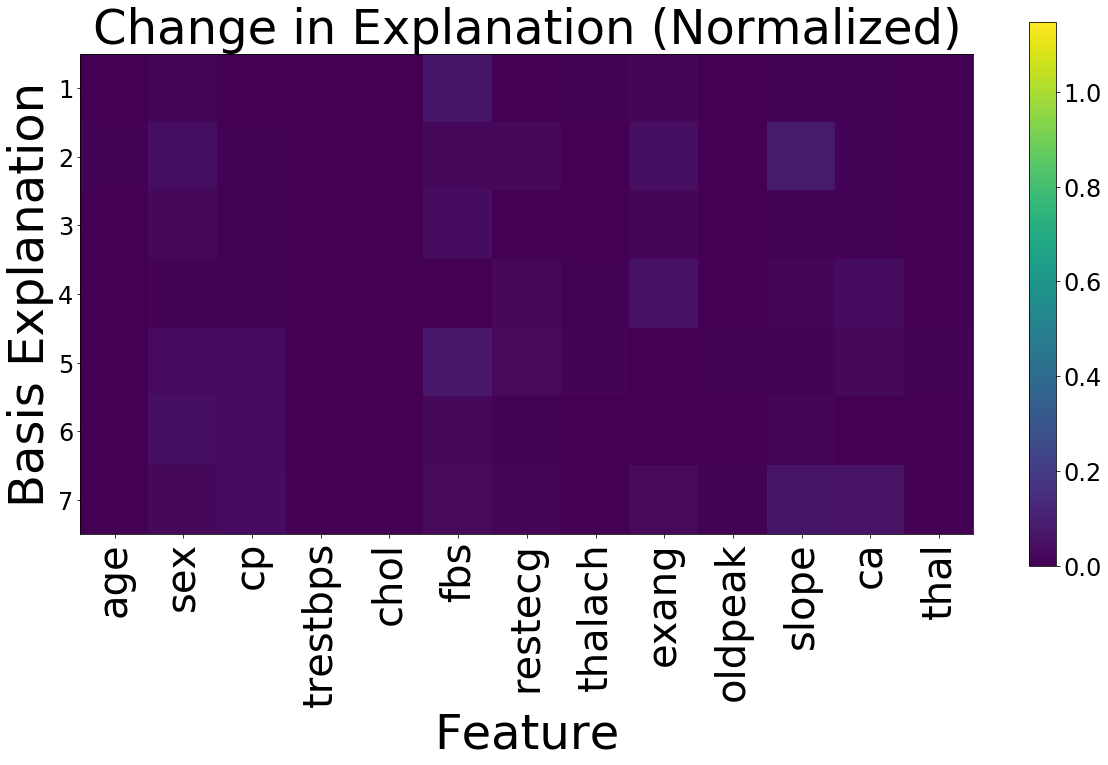

In [ ]:
# Evaluate how much the other explanations changed

deltas_original = np.load("../Reproduction/Heart-K/deltas" + str(k) + ".npy")

plot_change(deltas, deltas_original, "heart-corrupted-similarity.png", feature_names = feature_names)